Here’s the code that underpins the methodology for my temperature prediction app. I began this project during my junior year and continued to develop it throughout my senior year. The following section includes some basic analysis I conducted on the dataset from Charlotte Douglas International Airport.

In [ ]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


weather = pd.read_csv('sample_data/Charlotte_Douglas_Weather_Dataset.csv', index_col='DATE')


<ipython-input-28-0e82b93870f7>:7: DtypeWarning: Columns (7,9,13,19,25,33,35,37,39,41,43,45,47,49,51,53,71,73,75,77,79,81,83,85,87,89,91,93,95) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv('sample_data/Charlotte_Douglas_Weather_Dataset.csv', index_col='DATE')


We can import our data from the CSV file and use the date column as the index. Below, we display the first few rows of the dataframe.

In [ ]:

weather.head(3)



,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,ACMH,ACMH_ATTRIBUTES,ACSH,ACSH_ATTRIBUTES,AWND,...,WT19,WT19_ATTRIBUTES,WT21,WT21_ATTRIBUTES,WT22,WT22_ATTRIBUTES,WV03,WV03_ATTRIBUTES,WV20,WV20_ATTRIBUTES
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-01,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",35.22254,-80.95433,222.6,90.0,",,X",100.0,",,X",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-02,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",35.22254,-80.95433,222.6,30.0,",,X",0.0,",,X",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-03,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",35.22254,-80.95433,222.6,40.0,",,X",40.0,",,X",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataframe has too many columns. We can streamline it by selecting only the necessary columns and renaming them for better readability.

In [ ]:
real_weather = weather[['PRCP','SNOW','SNWD','TMAX','TMIN']].copy()
real_weather.columns = ['precip', 'snow', 'snow_depth', 'temp_max','temp_min']
real_weather.index = pd.to_datetime(real_weather.index)


real_weather.head(3)

,precip,snow,snow_depth,temp_max,temp_min
DATE,,,,,
1970-01-01,0.08,0.0,0.0,43,33
1970-01-02,0.00,0.0,0.0,44,25
1970-01-03,0.00,0.0,0.0,47,27


Now that the dataframe is streamlined, we can check for any null values present.

In [ ]:
null_vals = real_weather[pd.isnull(real_weather['temp_max'])]

null_vals

,precip,snow,snow_depth,temp_max,temp_min
DATE,,,,,


It appears there are no null values after our initial check. However, the data documentation notes that a value of 9 in a field signifies missing data. We should update these values accordingly.

In [ ]:
real_nulls = real_weather.eq(9999).sum()
real_nulls

precip        0
snow          0
snow_depth    0
temp_max      0
temp_min      0
dtype: int64


Great news—there are no missing values!

Below, you can see the `temp_max` and `temp_min` data points plotted. Charlotte Douglas International Airport maintained a consistent record-keeping process!

<Axes: xlabel='DATE'>

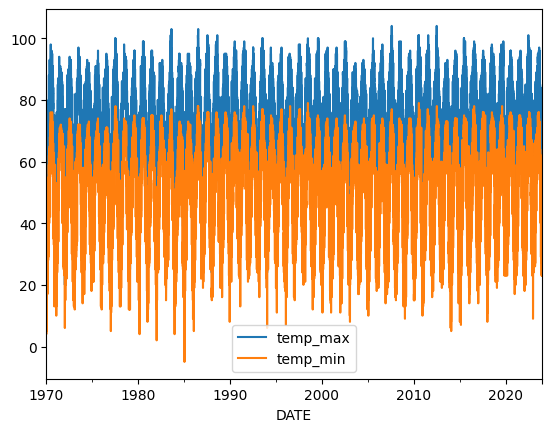

In [ ]:

real_weather[['temp_max','temp_min']].plot()

Below, you can see that we have consistent data spanning from 1970 up until 2023, which is the date I requested the data from NOAA.

In [ ]:

x = real_weather.index.year.value_counts().sort_index()
x

DATE
1970    365
1971    365
1972    366
1973    365
1974    365
1975    365
1976    366
1977    365
1978    365
1979    365
1980    366
1981    365
1982    365
1983    365
1984    366
1985    365
1986    365
1987    365
1988    366
1989    365
1990    365
1991    365
1992    366
1993    365
1994    365
1995    365
1996    366
1997    365
1998    365
1999    365
2000    366
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    365
2023    354
Name: count, dtype: int64

Our precipitation data is also quite consistent! Notably, in 1997, there was a record 6.88 inches of rain—that’s impressive!

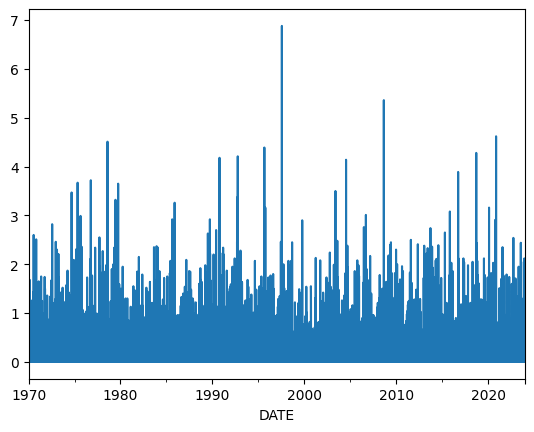

In [ ]:
real_weather['precip'].plot()

total_yearly_rain = real_weather.groupby(real_weather.index.year).sum()['precip']

#display(f"{total_yearly_rain.max()} inches of rain in the year {total_yearly_rain.idxmax()}")


Now, we’ll use our ridge regression model to predict the maximum and minimum temperatures. To start, we’ll create a target column by shifting the `temp_max` values backward by one day to predict the temperature for the following day.

In [ ]:

real_weather['target_max'] = real_weather.shift(-1)['temp_max']
real_weather['target_min'] = real_weather.shift(-1)['temp_min']


"""
We have some null values at the tail of the dataset given the shifted values so we will
just take them out as they are not important.
"""
real_weather = real_weather.iloc[:-1,:].copy()


"""
Next we will use ridge regression or L2 regularizaion to stop the model from overfitting the data.
We want to fix the multicollinearity in our decision tree regression.
"""

reg_max = Ridge(alpha=.1)
reg_min = Ridge(alpha=.1)


"""
Now we can select our featurs for our machine learning model.
Today we will just go with percipitation, max temperature, and minimum temp.
"""

features = ['precip','temp_max','temp_min']


"""
Also we will go with splitting the data into training and testing data.
I will go with the standard 80ish / 20ish split that is regularly used.
"""

#Train the model using historical data from 1970-2012
train = real_weather.loc[:'2015-12-31']

#Test the model on data from 2013-2023
test = real_weather.loc['2016-01-01':]

"""
Here we are going to fit our training data to the ridge regression model for
temp_max and temp_min
"""

reg_max.fit(train[features], train['target_max'])
reg_min.fit(train[features], train['target_min'])


predict_max = reg_max.predict(test[features])
predict_min = reg_min.predict(test[features])


min_error = round(mean_absolute_error(test['target_min'],predict_min),3)
max_error = round(mean_absolute_error(test['target_max'],predict_max),3)


print(f"For our regularization model(s)\nmax_temp error: {max_error} degrees \nmin_temp error: {min_error} degrees ")




For our regularization model(s)
max_temp error: 5.083 degrees 
min_temp error: 4.494 degrees 




We can see that our model’s predictions are off by about 4 or 5 degrees, which isn't ideal but still reasonable. Next, we’ll plot the predicted temperatures alongside the actual temperatures to visualize the performance of our model.

In [ ]:
def gen_predictions(predictions: list, real_weather: pd.DataFrame, reg_min,reg_max):
  train = real_weather.loc[:'2020-12-31']
  test = real_weather.loc['2021-01-01':]

  reg_max.fit(train[features], train['target_max'])
  reg_min.fit(train[features], train['target_min'])


  predict_max = reg_max.predict(test[features])
  predict_min = reg_min.predict(test[features])


  min_error = round(mean_absolute_error(test['target_min'],predict_min),3)
  max_error = round(mean_absolute_error(test['target_max'],predict_max),3)

  result_min = pd.concat([test['target_min'], pd.Series(predict_min, index = test.index)], axis=1)
  result_max = pd.concat([test['target_max'], pd.Series(predict_max, index = test.index)], axis=1)

  columns = ['actual','predictions']

  result_min.columns = columns
  result_max.columns = columns

  return min_error, max_error, result_min, result_max



<Axes: title={'center': 'result_min'}, xlabel='DATE'>

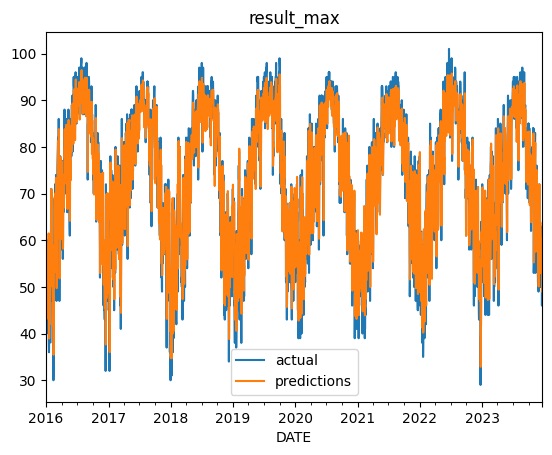

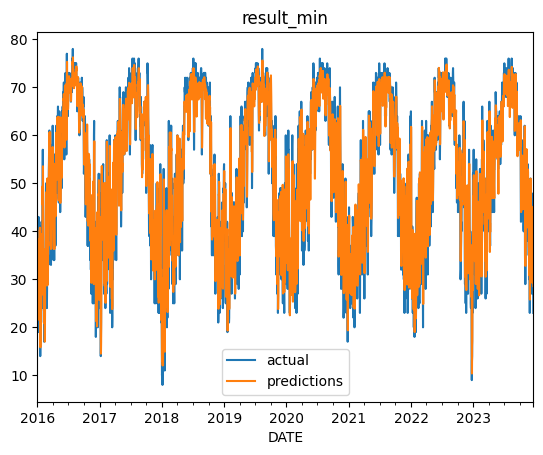

In [ ]:
result_min = pd.concat([test['target_min'], pd.Series(predict_min, index = test.index)], axis=1)
result_max = pd.concat([test['target_max'], pd.Series(predict_max, index = test.index)], axis=1)

columns = ['actual','predictions']

result_min.columns = columns
result_max.columns = columns

result_max.plot(title= "result_max")
result_min.plot(title = "result_min")



Our model is performing reasonably well, but we can apply some techniques to potentially improve its accuracy.

First, we’ll calculate the rolling mean of the past 30 days for both the minimum and maximum temperatures. Afterward, we'll remove the last 30 days from the dataset, as these will contain NaN values due to the rolling mean calculation.

For our regularization model(s)
max_temp error: 5.005 degrees 
min_temp error: 4.35 degrees 


<Axes: title={'center': 'max temp result'}, xlabel='DATE'>

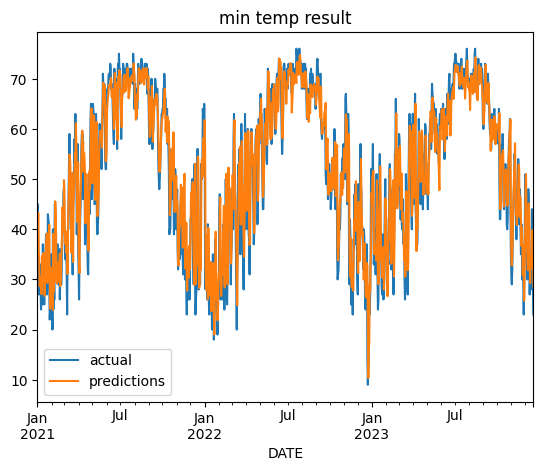

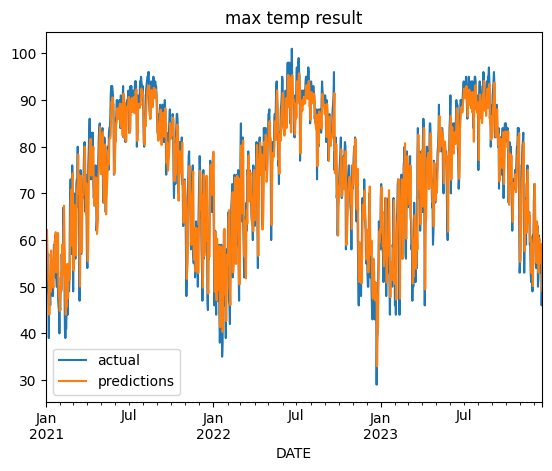

In [ ]:
#get the mean of the last 30 days for that given data point
real_weather['month_max'] = real_weather['temp_max'].rolling(30).mean()
real_weather['month_min'] = real_weather['temp_min'].rolling(30).mean()

#ratio of how diferent the mean temp is from the temp on a given day
real_weather['month_day_max'] = real_weather['month_max'] / real_weather['temp_max']
real_weather['month_day_min'] = real_weather['month_min'] / real_weather['temp_min']


#check the ratio of the maximum and minimum temp on a given day
real_weather['max_min'] = real_weather['temp_max'] / real_weather['temp_min']


#take off the last 30 days of the dataset as its full of NaNa
real_weather = real_weather.iloc[30:,:].copy()

max_predictiors = ['precip', 'snow', 'snow_depth', 'temp_max','temp_min','month_max','month_day_max','max_min']
min_predictiors = ['precip', 'snow', 'snow_depth', 'temp_max','temp_min','month_min','month_day_min','max_min']


min_error,_, min_res,_ = gen_predictions(min_predictiors, real_weather,reg_min,reg_max)
_,max_error,_,max_res = gen_predictions(max_predictiors, real_weather, reg_min,reg_max)

print(f"For our regularization model(s)\nmax_temp error: {max_error} degrees \nmin_temp error: {min_error} degrees ")

min_res.plot(title='min temp result')
max_res.plot(title = 'max temp result')


Below is a class that consolidates everything, allowing you to (somewhat) accurately predict tomorrow's high and low temperatures!

In [ ]:
class Weather_L2_Regularization():

  #iniialize the class with all the essentials
  def __init__(self):

    weather = pd.read_csv('sample_data/Charlotte_Douglas_Weather_Dataset.csv', index_col='DATE')
    real_weather.index = pd.to_datetime(real_weather.index)


    self.reg_max = Ridge(alpha=.1)
    self.reg_min = Ridge(alpha=.1)
    self.real_weather = self.clean_data(weather)
    self.features = ['precip', 'snow', 'snow_depth', 'temp_max','temp_min','month_min','month_day_max','month_day_min','max_min']
    self.train_data()


  def train_data(self):
    train = real_weather.loc[:'2022-12-31']
    test = real_weather.loc['2023-01-01':]

    self.reg_max.fit(train[self.features], train['target_max'])
    self.reg_min.fit(train[self.features], train['target_min'])



  def clean_data(self,dataframe: pd.DataFrame) -> pd.DataFrame:
    #Clean the data and add some feilds to help improve the ridge regression
    real_weather = dataframe[['PRCP','SNOW','SNWD','TMAX','TMIN']].copy()
    real_weather.columns = ['precip', 'snow', 'snow_depth', 'temp_max','temp_min']
    real_weather.index = pd.to_datetime(real_weather.index)
    real_weather['target_max'] = real_weather.shift(-1)['temp_max']
    real_weather['target_min'] = real_weather.shift(-1)['temp_min']
    real_weather = real_weather.iloc[:-1,:].copy()


    #get the mean of the last 30 days for that given data point
    real_weather['month_max'] = real_weather['temp_max'].rolling(30).mean()
    real_weather['month_min'] = real_weather['temp_min'].rolling(30).mean()

    #ratio of how diferent the mean temp is from the temp on a given day
    real_weather['month_day_max'] = real_weather['month_max'] / real_weather['temp_max']
    real_weather['month_day_min'] = real_weather['month_min'] / real_weather['temp_min']


    #check the ratio of the maximum and minimum temp on a given day
    real_weather['max_min'] = real_weather['temp_max'] / real_weather['temp_min']


    #take off the last 30 days of the dataset as its full of NaNa
    real_weather = real_weather.iloc[30:,:].copy()

    return real_weather


  def predict(self,today_temp_max,today_temp_min,today_percip=0,today_snow=0,today_snow_depth=0):

    today = self.real_weather.iloc[-1].copy()
    today['percip'] = today_percip
    today['snow'] = today_snow
    today['snow_depth'] = today_snow_depth
    today['temp_max'] = today_temp_max
    today['temp_min'] = today_temp_min
    today['month_max'] = self.real_weather['temp_max'].rolling(30).mean().iloc[-1]
    today['month_min'] = self.real_weather['temp_min'].rolling(30).mean().iloc[-1]
    today['month_day_max'] = today['month_max'] / today_temp_max
    today['month_day_min'] = today['month_min'] / today_temp_min
    today['max_min'] = today_temp_max / today_temp_min


    features = today[self.features].values.reshape(1,-1)

    pred_max = self.reg_max.predict(features)[0]
    pred_min = self.reg_min.predict(features)[0]


    return pred_max, pred_min



g = Weather_L2_Regularization()
res = g.predict(today_temp_max = 60, today_temp_min = 30)



print(res)










(59.447851076563666, 34.099264268515526)


<ipython-input-52-42cf1e87ca4f>:6: DtypeWarning: Columns (7,9,13,19,25,33,35,37,39,41,43,45,47,49,51,53,71,73,75,77,79,81,83,85,87,89,91,93,95) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv('sample_data/Charlotte_Douglas_Weather_Dataset.csv', index_col='DATE')
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [ ]:
real_weather.head(30)

,precip,snow,snow_depth,temp_max,temp_min,target_max,target_min,month_max,month_min,month_day_max,month_day_min,max_min
DATE,,,,,,,,,,,,
1970-01-31,0.00,0.0,0.0,50,24,54.0,25.0,45.100000,24.033333,0.902000,1.001389,2.083333
1970-02-01,0.02,0.0,0.0,54,25,65.0,45.0,45.433333,24.033333,0.841358,0.961333,2.160000
1970-02-02,0.65,0.0,0.0,65,45,50.0,21.0,46.033333,24.633333,0.708205,0.547407,1.444444
1970-02-03,0.60,0.0,0.0,50,21,36.0,12.0,46.300000,24.733333,0.926000,1.177778,2.380952
1970-02-04,0.00,0.0,0.0,36,12,47.0,23.0,45.900000,24.433333,1.275000,2.036111,3.000000
1970-02-05,0.00,0.0,0.0,47,23,52.0,23.0,46.200000,24.133333,0.982979,1.049275,2.043478
1970-02-06,0.00,0.0,0.0,52,23,54.0,29.0,46.733333,24.333333,0.898718,1.057971,2.260870
1970-02-07,0.00,0.0,0.0,54,29,56.0,37.0,47.833333,25.033333,0.885802,0.863218,1.862069
1970-02-08,0.00,0.0,0.0,56,37,53.0,32.0,48.866667,26.133333,0.872619,0.706306,1.513514
